# APIs with Python


APIs (application programming interfaces) are hosted on web servers. When you type www.google.com in your browser's address bar, your computer is actually asking the www.google.com server for a webpage, which it then returns to your browser. APIs work much the same way, except instead of your web browser asking for a webpage, your program asks for data. This data is usually returned in JSON format. 

To retrieve data, we make a request to a webserver. The server then replies with our data. In Python, we'll use the `requests` library to do this.



### Python Setup

In [1]:
# interacting with websites and web-APIs
import requests # easy way to interact with web sites and services

# data manipulation
from datascience import *
import numpy as np

%matplotlib inline

## Retrieving Patent Data about University of Maryland

We will use the `request` package to retrieve information about the patents that have been granted to inventors at University of Maryland, using the PatentsView API. This notebook goes over using the `request` package to get the data, as well as putting that data into a form that is usable. 

## How does the request package work?

We first need to understand what information can be accessed from the API. We use an example of the **PatentsView API** (www.patentsview.org) to make the API call and check the information we get. 

### About PatentsView API

The PatentsView platform is built on data derived from the US Patent and Trademark Office (USPTO) bulk data to link inventors, their organizations, locations, and overall patenting activity. The PatentsView API provides programmatic access to longitudinal data and metadata on patents, inventors, companies, and geographic locations since 1976. 

To access the API, we use the `request` function. In order to tell Python what to access, we need to specify the url of the API endpoint.

PatentsView has several API endpoints. An endpoint is a server route that is used to retrieve different data from the API. You can think of the endpoints as just specifying what types of data you want. Examples of PatentsView API endpoints are shown here: http://www.patentsview.org/api/doc.html

Many times, we need to request a key from the data provider in order to access an API. For example, if you wanted to access the Twitter API, then you would need to get a Twitter developer account and access token (see [https://developer.twitter.com/en/docs/basics/authentication/overview/oauth](https://developer.twitter.com/en/docs/basics/authentication/overview/oauth)). Currently no key is necessary to access the PatentsView API. 

### Making a Request
When you ping a website or portal for information this is called making a request. That is exactly what the `requests` library has been designed to do. However, we need to provide a query URL according to the format defined by PatentsView. The details on how to do that is explained [at this link.](https://www.patentsview.org/api/query-language.html)

Following the directions detailed in the link above, let's build our first query URL.

**Query String Format**

The query string is always a single JSON object: **{`<field>`:`<value>`}**, where `<field>` is the name of a database field and `<value>` is the value the field will be compared to for equality (Each API Endpoint section contains a list of the data fields that can be selected for inclusion in output datasets).

We use the following base URL for the Patents Endpoint:

**Base URL**: `http://www.patentsview.org/api/patents/query?q={criteria}`



## Task example: Pull patents for University of Maryland

In this example, we will only pull patents from one organization: University of Maryland. Let's go to the Patents Endpoint (http://www.patentsview.org/api/patent.html) and find the appropriate field for the organization's name. Based on looking at the APID documentation, we can see that the variable that we need is called `"assignee_organization"` (organization name, if assignee is organization).

> _Note_: **Assignee**: the name of the entity - company, foundation, partnership, holding company or individual - that owns the patent. In this example we are looking at universities (organization-level).

We will pull from the API using a step-by-step process:
- Build the query
- Get the response
- Check the response code
- Get the content
- Convert to table

By the end, we should have data about patents that we can work with using the tools we've already learned.

### Step 1. Build the URL query 

Let's build our first URL query by combining the base url with one criterion (name of the `assignee_organization`). This is based on the directions detailed [at this link.](https://www.patentsview.org/api/query-language.html)

To build it up, we start with the base url (`http://www.patentsview.org/api/patents/query?q=`) and add the criterion: (`{"assignee_organization":university of maryland"}`).

In [12]:
url = 'https://www.patentsview.org/api/patents/query?q={"assignee_organization":"university of maryland"}'

### Step 2. Get the response

Now let's get the response using the URL defined above, using the `requests` library.

In [13]:
r = requests.get(url)

### Step 3. Check the Response Code

Before you can do anything with a website or URL in Python, it’s a good idea to check the current status code of said portal.

The following are the response codes for the PatentsView API:

`200` - the query parameters are all valid; the results will be in the body of the response

`400` - the query parameters are not valid, typically either because they are not in valid JSON format, or a specified field or value is not valid; the “status reason” in the header will contain the error message

`500` -  there is an internal error with the processing of the query; the “status reason” in the header will contain the error message

Let's check the status of our response 

In [14]:
r.status_code  # Check the status code

200

We are good to go. Now let's get the content.

### Step 4. Get the Content
After a web server returns a response, you can collect the content you need by converting it into a JSON format.

JSON is a way to encode data structures like lists and dictionaries to strings that ensures that they are easily readable by machines. JSON is the primary format in which data is passed back and forth to APIs, and most API servers will send their responses in JSON format.

In [15]:
json = r.json()  # Convert response to JSON format

By default, we get information on `patent_id`, `patent_number`, and `patent_title`. At the end of the JSON you will see how many results are returned (variable `count`) and the total number of patents found (variable `total_patent_count`).

In [16]:
json  # View JSON

{'patents': [{'patent_id': '10002228',
   'patent_number': '10002228',
   'patent_title': 'Method for binding site identification by molecular dynamics simulation (silcs: site identification by ligand competitive saturation)'},
  {'patent_id': '10006019',
   'patent_number': '10006019',
   'patent_title': 'Methods for recovery of leaf proteins'},
  {'patent_id': '10010596',
   'patent_number': '10010596',
   'patent_title': 'Bacterial live vector vaccines expressing chromosomally-integrated foreign antigens'},
  {'patent_id': '10014561',
   'patent_number': '10014561',
   'patent_title': 'Systems, methods, and devices for health monitoring of an energy storage device'},
  {'patent_id': '10015616',
   'patent_number': '10015616',
   'patent_title': 'Sparse decomposition of head related impulse responses with applications to spatial audio rendering'},
  {'patent_id': '10016413',
   'patent_number': '10016413',
   'patent_title': 'Combination dopamine antagonist and opiate receptor antago

In [24]:
json['patents'][0]['patent_title']

'Method for binding site identification by molecular dynamics simulation (silcs: site identification by ligand competitive saturation)'

There are 1205 patents for University of Maryland, with 25 out of 1205 results returned (we will discuss how to change the number of returned results later in the notebook).

We want to be able to use this data, but it's a bit hard to in the current JSON format. We want to essentially take the information that is in the `patents` field within the dictionary and create a Table out of it. To do that, we'll need to take a little detour to introduce a few Python tools that will make our lives much easier.

### Lists and List Comprehension

Python lists are similar to arrays, but have slightly different properties. You can create basic python lists with square brackets and work them similar to arrays.

In [25]:
# Create an empty list
empty = []
empty

[]

In [26]:
# Create a list with some numbers
nums = [1,2,3,4,5]
nums

[1, 2, 3, 4, 5]

In [27]:
nums.append('test')
nums

[1, 2, 3, 4, 5, 'test']

#### List Comprehension

List comprehension is kind of like a compact `for` loop inside a list. You use it to generate a list of values with certain characteristics. For example, if we wanted to create a list with values from 0 to 9, we could use the following.

In [28]:
[i for i in np.arange(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Now, this isn't super interesting, because we could have just used the array itself. But, we can also do slight variations.

In [11]:
[2*i for i in np.arange(10)]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [12]:
nums = np.arange(10)
[i > 5 for i in nums]

[False, False, False, False, False, False, True, True, True, True]

In [13]:
sample_dict = {'one':1, 'two':2, 'three':3}

In [14]:
sample_dict['one']

1

### Step 5. Converting JSON into a Table

Now let's convert the JSON into a `Table`. To do this, let's first examine how the JSON looks.

In [29]:
type(json)

dict

In [30]:
json

{'patents': [{'patent_id': '10002228',
   'patent_number': '10002228',
   'patent_title': 'Method for binding site identification by molecular dynamics simulation (silcs: site identification by ligand competitive saturation)'},
  {'patent_id': '10006019',
   'patent_number': '10006019',
   'patent_title': 'Methods for recovery of leaf proteins'},
  {'patent_id': '10010596',
   'patent_number': '10010596',
   'patent_title': 'Bacterial live vector vaccines expressing chromosomally-integrated foreign antigens'},
  {'patent_id': '10014561',
   'patent_number': '10014561',
   'patent_title': 'Systems, methods, and devices for health monitoring of an energy storage device'},
  {'patent_id': '10015616',
   'patent_number': '10015616',
   'patent_title': 'Sparse decomposition of head related impulse responses with applications to spatial audio rendering'},
  {'patent_id': '10016413',
   'patent_number': '10016413',
   'patent_title': 'Combination dopamine antagonist and opiate receptor antago

It can be a bit hard to tell, but `json` is a Python dictionary, with three keys: `patents`, `count`, and `total_patent_count`. Let's look at what each one contains.

In [31]:
json['patents']

[{'patent_id': '10002228',
  'patent_number': '10002228',
  'patent_title': 'Method for binding site identification by molecular dynamics simulation (silcs: site identification by ligand competitive saturation)'},
 {'patent_id': '10006019',
  'patent_number': '10006019',
  'patent_title': 'Methods for recovery of leaf proteins'},
 {'patent_id': '10010596',
  'patent_number': '10010596',
  'patent_title': 'Bacterial live vector vaccines expressing chromosomally-integrated foreign antigens'},
 {'patent_id': '10014561',
  'patent_number': '10014561',
  'patent_title': 'Systems, methods, and devices for health monitoring of an energy storage device'},
 {'patent_id': '10015616',
  'patent_number': '10015616',
  'patent_title': 'Sparse decomposition of head related impulse responses with applications to spatial audio rendering'},
 {'patent_id': '10016413',
  'patent_number': '10016413',
  'patent_title': 'Combination dopamine antagonist and opiate receptor antagonist treatment of addictive b

In [32]:
text = ['this', 'is', 'some', 'text']
for i in text:
    print(i)

this
is
some
text


In [33]:
for i in json['patents']:
    print(i)
    print('\n')

{'patent_id': '10002228', 'patent_number': '10002228', 'patent_title': 'Method for binding site identification by molecular dynamics simulation (silcs: site identification by ligand competitive saturation)'}


{'patent_id': '10006019', 'patent_number': '10006019', 'patent_title': 'Methods for recovery of leaf proteins'}


{'patent_id': '10010596', 'patent_number': '10010596', 'patent_title': 'Bacterial live vector vaccines expressing chromosomally-integrated foreign antigens'}


{'patent_id': '10014561', 'patent_number': '10014561', 'patent_title': 'Systems, methods, and devices for health monitoring of an energy storage device'}


{'patent_id': '10015616', 'patent_number': '10015616', 'patent_title': 'Sparse decomposition of head related impulse responses with applications to spatial audio rendering'}


{'patent_id': '10016413', 'patent_number': '10016413', 'patent_title': 'Combination dopamine antagonist and opiate receptor antagonist treatment of addictive behavior'}


{'patent_id':

In [ ]:
json['count']

In [ ]:
json['total_patent_count']

The `patents` key has, itself, a list of dictionaries. Each individual dictionary has information about an individual patent, so each element in the list is a patent. The other two are summaries about the patent, showing the count of patents that we pulled, along with the overall number of patents for University of Maryland.

Because the patent information is inside a list, we'll need to access information from the `patents` key by iterating through each element of that list and pulling the relevant information from each patent in that list. To do this, we'll use list comprehension.

In [34]:
patent_id = [a['patent_id'] for a in json['patents']]
patent_number = [a['patent_number'] for a in json['patents']]
patent_title = [a['patent_title'] for a in json['patents']]
patents = Table().with_columns('patent_id', patent_id, 'patent_number', patent_number, 'patent_title', patent_title)

Above, the `a` represents an individual patent dictionary, which is an element of the list in `json['patents']`. We pull out the individual fields for each patent (`patent_id`, `patent_number`, and `patent_title`, then put them all into a Table. Let's take a look at the table.

In [35]:
patents

patent_id,patent_number,patent_title
10002228,10002228,Method for binding site identification by molecular dyna ...
10006019,10006019,Methods for recovery of leaf proteins
10010596,10010596,Bacterial live vector vaccines expressing chromosomally- ...
10014561,10014561,"Systems, methods, and devices for health monitoring of a ..."
10015616,10015616,Sparse decomposition of head related impulse responses w ...
10016413,10016413,Combination dopamine antagonist and opiate receptor anta ...
10017248,10017248,Flapping wing aerial vehicles
10017545,10017545,Compositions and vaccines comprising vesicles and method ...
10018385,10018385,"Solid-state heating or cooling systems, devices, and methods"
10019006,10019006,"Surface vehicle trajectory planning systems, devices, an ..."


### <span style="color:red">Checkpoint 1: Pull patent data for another university</span>

Now try pulling patent data for Georgetown University:
- build a query URL;
- make a request;
- get the response in JSON format;
- note the total number of patents;
- convert the JSON to a Table.

In [ ]:
url = 'http://www.patentsview.org/api/patents/query?q={"assignee_organization":"georgetown university"}'

r = requests.get(url)  
r.status_code

In [ ]:
gu_json = r.json()

In [ ]:
gu_json['total_patent_count']

In [ ]:
patent_id = [a['patent_id'] for a in gu_json['patents']]
patent_number = [a['patent_number'] for a in gu_json['patents']]
patent_title = [a['patent_title'] for a in gu_json['patents']]
gu_patents = Table().with_columns('patent_id', patent_id, 'patent_number', patent_number, 'patent_title', patent_title)

In [ ]:
gu_patents

## Adding to the query other fields of interest

Above we were able to pull data with the default information on the patents (`patent_id`, `patent_number`, `patent_title`). 

What if we want to know about the patent title and patent year?

Let's look for those variables in the API Endpoint (http://www.patentsview.org/api/patent.html), and add those fields to our query.

To the URL created above, we will add the fields parameter: `&f=["patent_title","patent_year"]`

In [36]:
url = 'http://www.patentsview.org/api/patents/query?q={"assignee_organization":"university of maryland"}&f=["patent_title","patent_year", "patent_abstract"]'

In [37]:
r = requests.get(url)  # Get response from the URL
r.status_code  # Check the status code

200

In [38]:
json = r.json()  # Convert response to JSON format

In [39]:
json  # View JSON

{'patents': [{'patent_title': 'Method for binding site identification by molecular dynamics simulation (silcs: site identification by ligand competitive saturation)',
   'patent_year': '2018',
   'patent_abstract': "The invention describes an explicit solvent all-atom molecular dynamics methodology (SILCS: Site Identification by Ligand Competitive Saturation) that uses small aliphatic and aromatic molecules plus water molecules to map the affinity pattern of a large molecule for hydrophobic groups, aromatic groups, hydrogen bond donors, and hydrogen bond acceptors. By simultaneously incorporating ligands representative of all these functionalities, the method is an in silico free energy-based competition assay that generates three-dimensional probability maps of fragment binding (FragMaps) indicating favorable fragment:large molecule interactions. The FragMaps may be used to qualitatively inform the design of small-molecule ligands or as scoring grids for high-throughput in silico dock

In [40]:
patent_title = [a['patent_title'] for a in json['patents']]
patent_year = [a['patent_year'] for a in json['patents']]
patent_abstract = [a['patent_abstract'] for a in json['patents']]

patents = Table().with_columns('patent_title', patent_title, 
                               'patent_year', patent_year,
                              'patent_abstract', patent_abstract)
patents

patent_title,patent_year,patent_abstract
Method for binding site identification by molecular dyna ...,2018,The invention describes an explicit solvent all-atom mol ...
Methods for recovery of leaf proteins,2018,A novel method for processing soluble plant leaf protein ...
Bacterial live vector vaccines expressing chromosomally- ...,2018,Bacterial live vector vaccines represent a vaccine devel ...
"Systems, methods, and devices for health monitoring of a ...",2018,A health monitoring device includes an ultrasound source ...
Sparse decomposition of head related impulse responses w ...,2018,This application describes methods of signal processing ...
Combination dopamine antagonist and opiate receptor anta ...,2018,The present invention is directed to a method of treatin ...
Flapping wing aerial vehicles,2018,An autonomous flapping wing aerial vehicle can have a ve ...
Compositions and vaccines comprising vesicles and method ...,2018,"The disclosure relates to compositions, pharmaceutical c ..."
"Solid-state heating or cooling systems, devices, and methods",2018,A system for heating/cooling includes a plurality of the ...
"Surface vehicle trajectory planning systems, devices, an ...",2018,A planning module for a water surface vehicle can determ ...


In [41]:
print(patents.column('patent_abstract')[6])

An autonomous flapping wing aerial vehicle can have a vehicle body, a pair of flapping wings, tunable wing hinges, and elastic drive mechanisms. The tunable wing hinges can be coupled to the flapping wings. Each wing hinge can be constructed to deliver a force to a respective one of the flapping wings to alter end points of a stroke thereof. The elastic drive mechanisms can rotate the flapping wings about pivot points to produce the strokes of the flapping wings. The elastic drive mechanism can be driven at or near a resonance thereof. Alterations to the strokes of the flapping wings produced by the combined effect of the tunable wing hinges and the elastic drive mechanisms, operating in parallel, can provide steering control of the aerial vehicle.


### <span style="color:red">Checkpoint 2: Add other fields</span>

Try adding other fields of interest. Go to the Patents Endpoint (http://www.patentsview.org/api/patent.html) and pick other 2 fields of interest to add to the query and get the results.

## Customize number of results

As you have noticed, by default, only 25 results are returned. To change the number of results returned (for example, 50 results), add the option parameter to the query URL: `&o={"per_page":50}`


In [42]:
url = 'http://www.patentsview.org/api/patents/query?q={"assignee_organization":"university of maryland"}&f=["patent_title","patent_year", "patent_abstract"]&o={"per_page":1300}'

In [43]:
r = requests.get(url)  # Get response from the URL
r.status_code  # Check the status code

200

In [44]:
json = r.json()  # Convert response to JSON format

Now the JSON shows 50 results (as noted in the variable `count` at the bottom of the JSON)

In [45]:
json

{'patents': [{'patent_title': 'Method for binding site identification by molecular dynamics simulation (silcs: site identification by ligand competitive saturation)',
   'patent_year': '2018',
   'patent_abstract': "The invention describes an explicit solvent all-atom molecular dynamics methodology (SILCS: Site Identification by Ligand Competitive Saturation) that uses small aliphatic and aromatic molecules plus water molecules to map the affinity pattern of a large molecule for hydrophobic groups, aromatic groups, hydrogen bond donors, and hydrogen bond acceptors. By simultaneously incorporating ligands representative of all these functionalities, the method is an in silico free energy-based competition assay that generates three-dimensional probability maps of fragment binding (FragMaps) indicating favorable fragment:large molecule interactions. The FragMaps may be used to qualitatively inform the design of small-molecule ligands or as scoring grids for high-throughput in silico dock

In [46]:
patent_title = [a['patent_title'] for a in json['patents']]
patent_year = [a['patent_year'] for a in json['patents']]
patent_abstract = [a['patent_abstract'] for a in json['patents']]

patents = Table().with_columns('patent_title', patent_title, 
                               'patent_year', patent_year,
                              'patent_abstract', patent_abstract)
patents

patent_title,patent_year,patent_abstract
Method for binding site identification by molecular dyna ...,2018,The invention describes an explicit solvent all-atom mol ...
Methods for recovery of leaf proteins,2018,A novel method for processing soluble plant leaf protein ...
Bacterial live vector vaccines expressing chromosomally- ...,2018,Bacterial live vector vaccines represent a vaccine devel ...
"Systems, methods, and devices for health monitoring of a ...",2018,A health monitoring device includes an ultrasound source ...
Sparse decomposition of head related impulse responses w ...,2018,This application describes methods of signal processing ...
Combination dopamine antagonist and opiate receptor anta ...,2018,The present invention is directed to a method of treatin ...
Flapping wing aerial vehicles,2018,An autonomous flapping wing aerial vehicle can have a ve ...
Compositions and vaccines comprising vesicles and method ...,2018,"The disclosure relates to compositions, pharmaceutical c ..."
"Solid-state heating or cooling systems, devices, and methods",2018,A system for heating/cooling includes a plurality of the ...
"Surface vehicle trajectory planning systems, devices, an ...",2018,A planning module for a water surface vehicle can determ ...


### <span style="color:red">Checkpoint 3: Customize the number of results</span>

Try customizing the number of returned results using the options parameter. 

## Using the Data

Now that we've pulled the data, we need to use it somehow. We'll go over more advanced methods with text analysis, but here's an initial look at what types of patents are awarded to University of Maryland.

In [47]:
base_url = 'http://www.patentsview.org/api/patents/query?'
organization = 'q={"assignee_organization":"university of maryland"}'
variables = '&f=["patent_title","patent_year", "patent_type", "patent_abstract"]'
options = '&o={"per_page":1300}'

url = base_url + organization + variables + options
r = requests.get(url)  # Get response from the URL
r.status_code  # Check the status code

200

In [48]:
json = r.json()
patent_title = [a['patent_title'] for a in json['patents']]
patent_year = [a['patent_year'] for a in json['patents']]
patent_type = [a['patent_type'] for a in json['patents']]
patent_abstract = [a['patent_abstract'] for a in json['patents']]

patents = Table().with_columns('patent_title', patent_title,
                               'patent_year', patent_year,
                              'patent_type', patent_type,
                               'patent_abstract', patent_abstract)
patents.show(5)

patent_title,patent_year,patent_type,patent_abstract
Method for binding site identification by molecular dyna ...,2018,utility,The invention describes an explicit solvent all-atom mol ...
Methods for recovery of leaf proteins,2018,utility,A novel method for processing soluble plant leaf protein ...
Bacterial live vector vaccines expressing chromosomally- ...,2018,utility,Bacterial live vector vaccines represent a vaccine devel ...
"Systems, methods, and devices for health monitoring of a ...",2018,utility,A health monitoring device includes an ultrasound source ...
Sparse decomposition of head related impulse responses w ...,2018,utility,This application describes methods of signal processing ...


In [49]:
patents.group('patent_type')

patent_type,count
plant,6
reissue,1
utility,1236


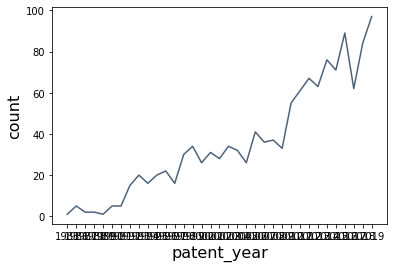

In [50]:
patents.group('patent_year').plot('patent_year')


In [51]:
# Find which titles have "method" in them
method = [('Method' in a) or ('method' in a) for a in patents.column('patent_abstract')]

# Add to Table, then count
patents = patents.with_column('is_method', method)
patents.group('is_method')

is_method,count
False,578
True,665


## Optional

Please feel free to explore and practice all available options in the API Query Language section of the PatentsView website (http://www.patentsview.org/api/query-language.html).